[![Supervision](https://media.roboflow.com/open-source/supervision/rf-supervision-banner.png?updatedAt=1678995927529)](https://github.com/roboflow/supervision)

# Supervision Quickstart

---

[![version](https://badge.fury.io/py/supervision.svg)](https://badge.fury.io/py/supervision)
[![downloads](https://img.shields.io/pypi/dm/supervision)](https://pypistats.org/packages/supervision)
[![license](https://img.shields.io/pypi/l/supervision)](https://github.com/roboflow/supervision/blob/main/LICENSE.md)
[![python-version](https://img.shields.io/pypi/pyversions/supervision)](https://badge.fury.io/py/supervision)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/supervision)

We write your reusable computer vision tools. Whether you need to load your dataset from your hard drive, draw detections on an image or video, or count how many detections are in a zone. You can count on us! 🤝

We hope that the resources in this notebook will help you get the most out of Supervision. Please browse the Supervision [Docs](https://roboflow.github.io/supervision/) for details, raise an [issue](https://github.com/roboflow/supervision/issues) on GitHub for support, and join our [discussions](https://github.com/roboflow/supervision/discussions) section for questions!

## Table of contents

- Before you start
- Install
- Detection API
    - Plug in your model
        - YOLO-NAS
        - YOLOv8
    - Annotate
        - `BoxAnnotator`
        - `MaskAnnotator`
    - Filter
        - By index, index list and index slice
        - By `class_id`
        - By `confidence`
        - By advanced logical condition
- Video API
    - `VideoInfo`
    - `get_video_frames_generator`
    - `VideoSink`
- Dataset API
    - `DetectionDataset.from_yolo`
    - Visualize annotations
    - `split`
    - `DetectionDataset.as_pascal_voc`


## ⚡ Before you start

**NOTE:** In this notebook, we aim to show - among other things - how simple it is to integrate `supervision` with popular object detection and instance segmentation libraries and frameworks. GPU access is optional but will certainly make the ride smoother.

<br>

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Nov 13 13:53:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


**NOTE:** During our demo, we will need some example images.

In [3]:
!mkdir {HOME}/images

**NOTE:** Feel free to use your images. Just make sure to put them into `images` directory that we just created. ☝️

In [4]:
%cd {HOME}/images

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-5.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-6.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-7.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-8.jpeg

/content/images


## ‍💻 Install

In [5]:
!pip install -q supervision

import supervision as sv
print(sv.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 2.3 MB/s eta 0:00:00
0.16.0


## 👁️ Detection API

- xyxy `(np.ndarray)`: An array of shape `(n, 4)` containing the bounding boxes coordinates in format `[x1, y1, x2, y2]`
- mask: `(Optional[np.ndarray])`: An array of shape `(n, W, H)` containing the segmentation masks.
- confidence `(Optional[np.ndarray])`: An array of shape `(n,)` containing the confidence scores of the detections.
- class_id `(Optional[np.ndarray])`: An array of shape `(n,)` containing the class ids of the detections.
- tracker_id `(Optional[np.ndarray])`: An array of shape `(n,)` containing the tracker ids of the detections.

### 🔌 Plug in your model

**NOTE:** In our example, we will focus only on integration with YOLO-NAS and YOLOv8. However, keep in mind that supervision allows seamless integration with many other models like SAM, Transformers, and YOLOv5. You can learn more from our [documentation](https://roboflow.github.io/supervision/detection/core/#detections).

In [6]:
import cv2

IMAGE_PATH = f"{HOME}/images/dog.jpeg"

image = cv2.imread(IMAGE_PATH)

### YOLO-NAS [📚](https://roboflow.github.io/supervision/detection/core/#supervision.detection.core.Detections.from_yolo_nas)

In [9]:
!pip install fastapi
!pip install kaleido
!pip install python-multipart
!pip install -q super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow 2.14.0 requires numpy>=1.23.5, but you have numpy 1.23.0 which is incompatible.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.7 MB/s eta 0:00:00
ER

In [8]:
from super_gradients.training import models

model = models.get('yolo_nas_l', pretrained_weights="coco")
result = model.predict(image)[0]
detections = sv.Detections.from_yolo_nas(result)

The console stream is logged into /root/sg_logs/console.log


[2023-11-13 13:55:49] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-13 13:55:49] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-13 13:55:50] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-11-13 13:55:56] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-13 13:55:56] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-13 13:55:56] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-13 13:55:56] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-11-13 13:55:56] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-11-13 13:55:56] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-11-13 13:55:56] WARNING - env_sanity_check.py - 

In [10]:
"detections", len(detections)

('detections', 7)

### Ultralytics [📚](https://roboflow.github.io/supervision/detection/core/#supervision.detection.core.Detections.from_ultralytics)

In [11]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 6.5 MB/s eta 0:00:00


In [12]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')
result = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(result)

100%|██████████| 21.5M/21.5M [00:00<00:00, 227MB/s]


In [13]:
"detections", len(detections)

('detections', 4)

### 👩‍🎨 Annotate

### BoxAnnotator [📚](https://roboflow.github.io/supervision/detection/annotate/#boxannotator)

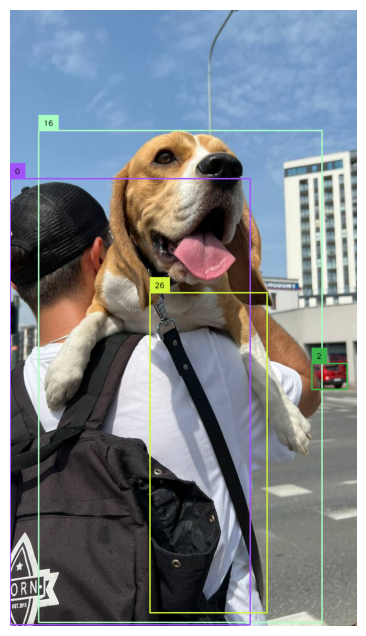

In [14]:
box_annotator = sv.BoxAnnotator()

annotated_image = box_annotator.annotate(image.copy(), detections=detections)

sv.plot_image(image=annotated_image, size=(8, 8))

**NOTE:** By default `sv.BoxAnnotator` use corresponding `class_id` as label, however, the labels can have arbitrary format.

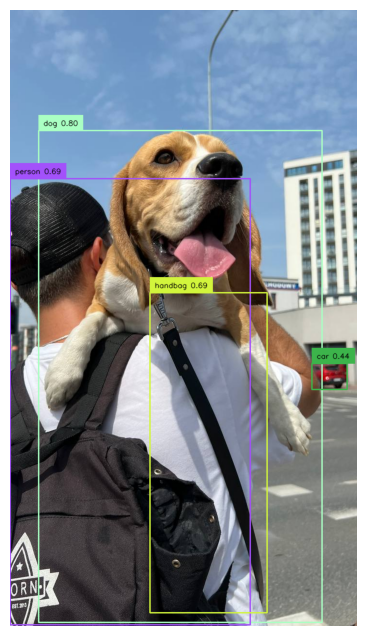

In [15]:
box_annotator = sv.BoxAnnotator()

labels = [
    f"{model.model.names[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]
annotated_image = box_annotator.annotate(image.copy(), detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(8, 8))

### MaskAnnotator [📚](https://roboflow.github.io/supervision/detection/annotate/#maskannotator)

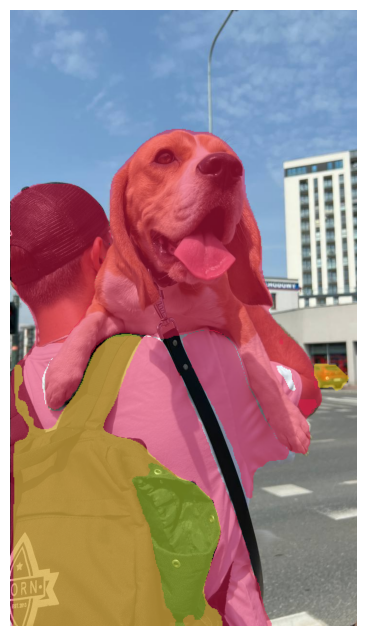

In [ ]:
mask_annotator = sv.MaskAnnotator(color_map="index")

annotated_image = mask_annotator.annotate(image.copy(), detections=detections)

sv.plot_image(image=annotated_image, size=(8, 8))

## 🗑 Filter [📚](https://roboflow.github.io/supervision/quickstart/detections/)

### By index, index list and index slice

**NOTE:** `sv.Detections` filter API allows you to access detections by index, index list or index slice

In [ ]:
detections_index = detections[0]
detections_index_list = detections[[0, 1, 3]]
detections_index_slice = detections[:2]

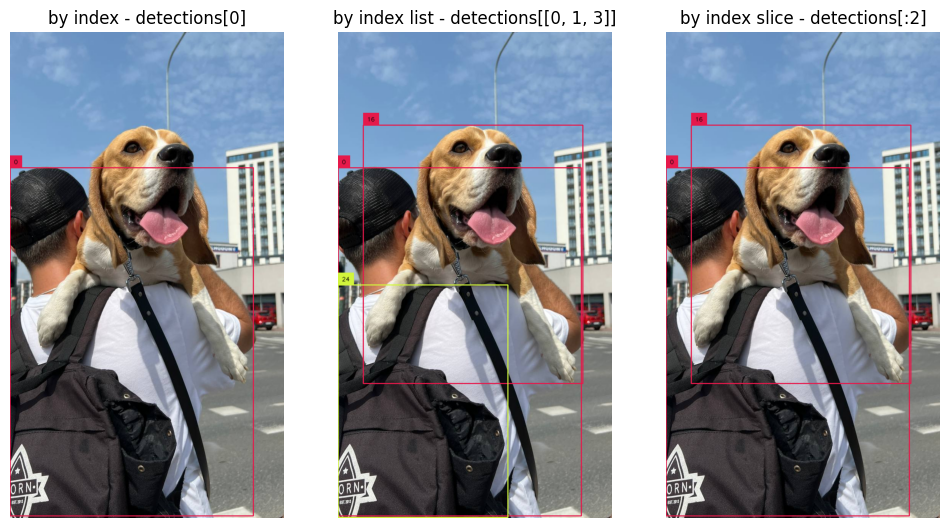

In [ ]:
box_annotator = sv.BoxAnnotator()

images = [
    box_annotator.annotate(image.copy(), detections=d)
    for d
    in [detections_index, detections_index_list, detections_index_slice]
]
titles = [
    "by index - detections[0]",
    "by index list - detections[[0, 1, 3]]",
    "by index slice - detections[:2]"
]

sv.plot_images_grid(images=images, titles=titles, grid_size=(1, 3))

### By class_id

**NOTE:** Let's use `sv.Detections` filter API to display only objects with `class_id == 0`

In [ ]:
detections_filtered = detections[detections.class_id == 0]

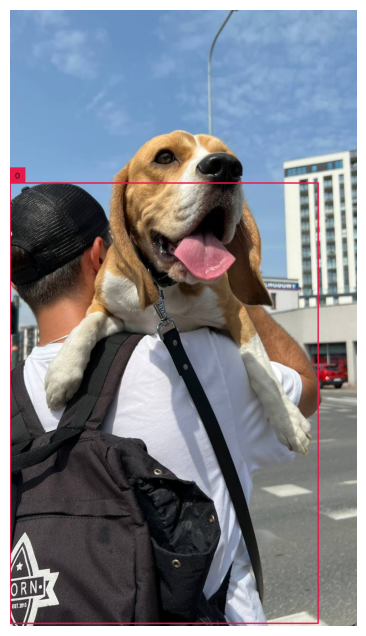

In [ ]:
box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detections=detections_filtered)
sv.plot_image(image=annotated_image, size=(8, 8))

### By confidence

**NOTE:** Let's use `sv.Detections` filter API to display only objects with `confidence > 0.75`

In [ ]:
detections_filtered = detections[detections.confidence > 0.75]

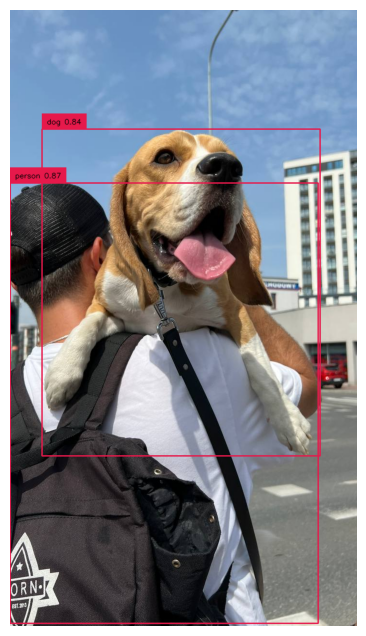

In [ ]:
box_annotator = sv.BoxAnnotator()
labels = [
    f"{model.model.names[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections_filtered.class_id, detections_filtered.confidence)
]
annotated_image = box_annotator.annotate(image.copy(), detections=detections_filtered, labels=labels)
sv.plot_image(image=annotated_image, size=(8, 8))

### By advanced logical condition

**NOTE:** Let's use `sv.Detections` filter API allows you to build advanced logical conditions. Let's select only detections with `class_id != 0` and `confidence > 0.75`.

In [ ]:
detections_filtered = detections[(detections.class_id != 0) & (detections.confidence > 0.75)]

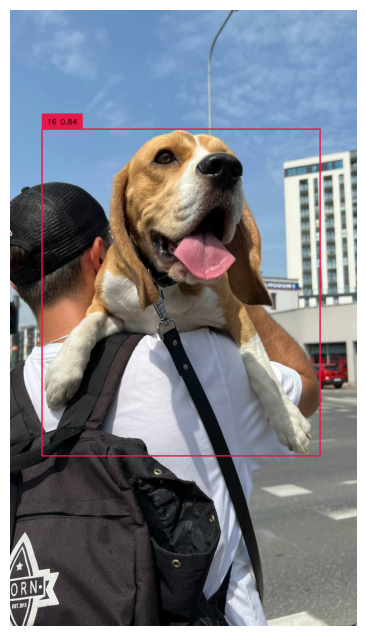

In [ ]:
box_annotator = sv.BoxAnnotator()
labels = [
    f"{class_id} {confidence:.2f}"
    for class_id, confidence
    in zip(detections_filtered.class_id, detections_filtered.confidence)
]
annotated_image = box_annotator.annotate(image.copy(), detections=detections_filtered, labels=labels)
sv.plot_image(image=annotated_image, size=(8, 8))

## 🎬 Video API

**NOTE:** `supervision` offers a lot of utils to make working with videos easier. Let's take a look at some of them.

**NOTE:** During our demo, we will need some example videos.

In [16]:
!mkdir {HOME}/videos

**NOTE:** Feel free to use your videos. Just make sure to put them into `videos` directory that we just created. ☝️

In [28]:
%cd {HOME}/videos

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/content/videos
--2023-11-13 14:05:05--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 142.251.2.102, 142.251.2.113, 142.251.2.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/54grh33d472lhc3s0fg2i3fmjni5rnct/1699884300000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=815996ff-3261-4f89-946e-b5d129bd2008 [following]
--2023-11-13 14:05:06--  https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/54grh33d472lhc3s0fg2i3fmjni5rnct/1699884300000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=815996ff-3261-4f89-946e-b5d129bd2008
Resolving doc-0s-ag-docs.googleusercontent.com (doc-0s-ag-docs.googleusercontent.com)... 142.2

In [24]:
VIDEO_PATH = f"{HOME}/videos/bici1.mp4"

### VideoInfo [📚](https://roboflow.github.io/supervision/utils/video/#videoinfo)

**NOTE:** `VideoInfo` allows us to easily retrieve information about video files, such as resolution, FPS and total number of frames.

In [25]:
sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)

VideoInfo(width=640, height=360, fps=29, total_frames=541)

### get_video_frames_generator [📚](https://roboflow.github.io/supervision/utils/video/#get_video_frames_generator)

In [26]:
frame_generator = sv.get_video_frames_generator(source_path=VIDEO_PATH)

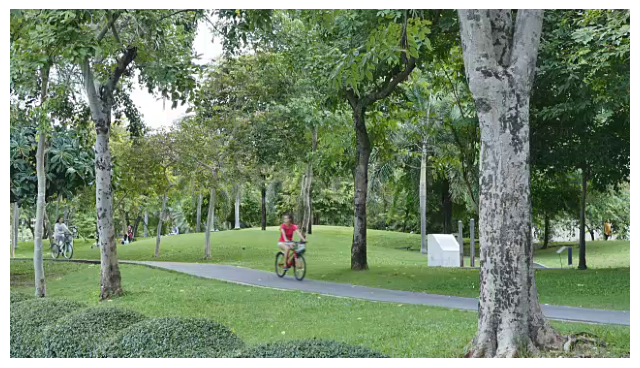

In [27]:
frame = next(iter(frame_generator))
sv.plot_image(image=frame, size=(8, 8))

### VideoSink [📚](https://roboflow.github.io/supervision/utils/video/#videosink)

In [22]:
RESULT_VIDEO_PATH = f"{HOME}/videos/vehicle-counting-result.mp4"

**NOTE:** Note that this time we have given a custom value for the `stride` parameter equal to `2`. As a result, `get_video_frames_generator` will return us every second video frame.

In [23]:
video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)

with sv.VideoSink(target_path=RESULT_VIDEO_PATH, video_info=video_info) as sink:
    for frame in sv.get_video_frames_generator(source_path=VIDEO_PATH, stride=2):
        sink.write_frame(frame=frame)

**NOTE:** If we once again use `VideoInfo` we will notice that the final video has 2 times fewer frames.

In [ ]:
sv.VideoInfo.from_video_path(video_path=RESULT_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=269)

## 🖼️ Dataset API

**NOTE:** In order to demonstrate the capabilities of the Dataset API, we need a dataset. Let's download one from [Roboflow Universe](https://universe.roboflow.com/). To do this we first need to install the `roboflow` pip package.

In [29]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires uvicorn, which is not installed.
super-gradients 3.4.1 requires pyparsing==2.4.5, but you have pyparsing 2.4.7 which is incompatible.
tensorflow 2.14.0 requires numpy>=1.23.5, but you have numpy 1.23.0 which is incompatible.


In [33]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("roboflow-jvuqo").project("fashion-assistant-segmentation")
dataset = project.version(5).download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.208, to fix: `pip install ultralytics==8.0.196`


Extracting Dataset Version Zip to fashion-assistant-segmentation-5 in yolov8::  18%|█▊        | 222/1254 [00:00<00:00, 2209.48it/s]

Extracting Dataset Version Zip to fashion-assistant-segmentation-5 in yolov8:: 100%|██████████| 1254/1254 [00:00<00:00, 2878.85it/s]


### DetectionDataset.from_yolo [📚](https://roboflow.github.io/supervision/dataset/core/#supervision.dataset.core.DetectionDataset.from_yolo)

**NOTE:** Currently Dataset API always loads loads images from hard drive. In the future, we plan to add lazy loading.

In [34]:
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/train/images",
    annotations_directory_path=f"{dataset.location}/train/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
)

In [35]:
len(ds)

573

In [36]:
ds.classes

['baseball cap',
 'hoodie',
 'jacket',
 'pants',
 'shirt',
 'shorts',
 'sneaker',
 'sunglasses',
 'sweatshirt',
 't-shirt']

### 🏷️ Visualize annotations

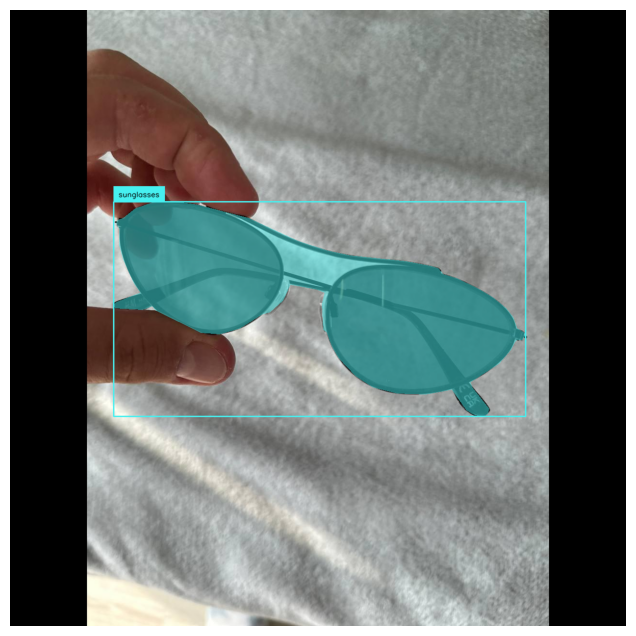

In [37]:
IMAGE_NAME = list(ds.images.keys())[0]

image = ds.images[IMAGE_NAME]
annotations = ds.annotations[IMAGE_NAME]

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

annotated_image = mask_annotator.annotate(image.copy(), detections=annotations)
annotated_image = box_annotator.annotate(annotated_image, detections=annotations, labels=labels)

sv.plot_image(image=annotated_image, size=(8, 8))

### split [📚](https://roboflow.github.io/supervision/dataset/core/#supervision.dataset.core.DetectionDataset.split)

In [ ]:
ds_train, ds_test = ds.split(split_ratio=0.8)

In [ ]:
"ds_train", len(ds_train), "ds_test", len(ds_test)

('ds_train', 458, 'ds_test', 115)

### DetectionDataset.as_pascal_voc [📚](https://roboflow.github.io/supervision/dataset/core/#supervision.dataset.core.DetectionDataset.as_pascal_voc)

In [ ]:
ds_train.as_pascal_voc(
    images_directory_path=f"{HOME}/datasets/result/images",
    annotations_directory_path=f"{HOME}/datasets/result/labels"
)

In [46]:
import numpy as np

model = YOLO("yolov8n.pt")
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {results.names[class_id]}"
        for class_id, tracker_id
        in zip(detections.class_id, detections.tracker_id)
    ]

    annotated_frame = box_annotator.annotate(
        frame.copy(), detections=detections)
    return label_annotator.annotate(
        annotated_frame, detections=detections, labels=labels)

sv.process_video(
    source_path="/content/videos/bici3.mp4",
    target_path="/content/videos/result3.mp4",
    callback=callback
)


0: 384x640 1 person, 10.2ms
Speed: 1.5ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.3ms
Speed: 1.4ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.2ms
Speed: 1.2ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.1ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.6ms
Speed: 1.1ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 0.6ms

## 🏆 Congratulations

### Learning Resources

- [Documentation](https://roboflow.github.io/supervision/)
- [GitHub](https://github.com/roboflow/supervision)
- [YouTube Supervision Playlist](https://www.youtube.com/playlist?list=PLZCA39VpuaZaoGIohe9aXVMm24MRvfu1E)